<a href="https://colab.research.google.com/github/qhung23125005/AIO/blob/main/AIO24/Module6/RNN/HourlyTemperatureForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

#Data

##Download data

In [ ]:
!gdown 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO

Downloading...
From: https://drive.google.com/uc?id=178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
To: /content/dataset.zip
100% 2.35M/2.35M [00:00<00:00, 15.1MB/s]


In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/weatherHistory.csv  


##Load data

In [ ]:
dataset_path = './dataset/weatherHistory.csv'

df = pd.read_csv(dataset_path)
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [ ]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']
univariate_df

,Temperature (C)
Formatted Date,
2006-04-01 00:00:00.000 +0200,9.472222
2006-04-01 01:00:00.000 +0200,9.355556
2006-04-01 02:00:00.000 +0200,9.377778
2006-04-01 03:00:00.000 +0200,8.288889
2006-04-01 04:00:00.000 +0200,8.755556
...,...
2016-09-09 19:00:00.000 +0200,26.016667
2016-09-09 20:00:00.000 +0200,24.583333
2016-09-09 21:00:00.000 +0200,22.038889


##Apply Slicing window technique

In [ ]:
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx+window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels

In [ ]:
input_size = 6
label_size = 1
offset = 1

In [ ]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df, 0, train_end_idx, input_size, label_size, offset
)

X_val, y_val = slicing_window(
    univariate_df, train_end_idx, val_end_idx, input_size, label_size, offset
)

X_test, y_test = slicing_window(
    univariate_df, val_end_idx, None, input_size, label_size, offset
)

##Create Pytorch dataset

In [ ]:
class WeatherForcast(nn.Module):
  def __init__(self, X, y, transform = None):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    x = self.X[idx]
    y = self.y[idx]

    if self.transform:
      x = self.transform(x)

    x = torch.tensor(x, dtype = torch.float32)
    y = torch.tensor(y, dtype = torch.float32)

    return x, y

##Create dataloader

In [ ]:
train_dataset = WeatherForcast(X_train, y_train)
val_dataset = WeatherForcast(X_val, y_val)
test_dataset = WeatherForcast(X_test, y_test)

train_batch_size = 128
test_batch_size = 8

train_dataloader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size = test_batch_size,
    shuffle = False
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size = test_batch_size,
    shuffle = False
)

#Modeling

##Model class

In [ ]:
class WeatherForcastor(nn.Module):
  def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
    super().__init__()
    self.rnn = nn.LSTM(embedding_dim, hidden_size, n_layers, batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x, _ = self.rnn(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc(x)

    return x

##Training and evaluating function

In [ ]:
def evaluate(model, criterion, data_loader, device):
  model.eval()
  losses = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())

  loss = sum(losses)/len(losses)
  return loss

In [ ]:
def fit(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    device,
    epochs
):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    batch_train_losses = []
    model.train()
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses)/len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss = evaluate(model, criterion, val_loader, device)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print('-'*50)

  return train_losses, val_losses

##Train model

In [ ]:
embedding_dim = 1
hidden_dim = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForcastor(
    embedding_dim, hidden_dim, n_layers, dropout_prob
).to(device)

In [ ]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_losses, val_losses = fit(
    model,
    criterion,
    optimizer,
    train_dataloader,
    val_dataloader,
    device,
    epochs
)

Epoch 1/50: Train Loss: 122.8370, Val Loss: 39.4073
--------------------------------------------------
Epoch 2/50: Train Loss: 29.0121, Val Loss: 7.1034
--------------------------------------------------
Epoch 3/50: Train Loss: 14.5620, Val Loss: 3.1530
--------------------------------------------------
Epoch 4/50: Train Loss: 11.5096, Val Loss: 2.8568
--------------------------------------------------
Epoch 5/50: Train Loss: 10.6208, Val Loss: 2.1412
--------------------------------------------------
Epoch 6/50: Train Loss: 10.1510, Val Loss: 1.7050
--------------------------------------------------
Epoch 7/50: Train Loss: 9.6932, Val Loss: 1.6426
--------------------------------------------------
Epoch 8/50: Train Loss: 9.4492, Val Loss: 1.6146
--------------------------------------------------
Epoch 9/50: Train Loss: 9.2545, Val Loss: 1.9615
--------------------------------------------------
Epoch 10/50: Train Loss: 9.1142, Val Loss: 1.7365
------------------------------------------

##Evaluate

In [ ]:
val

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

TypeError: 'MSELoss' object is not iterable

##Visualize

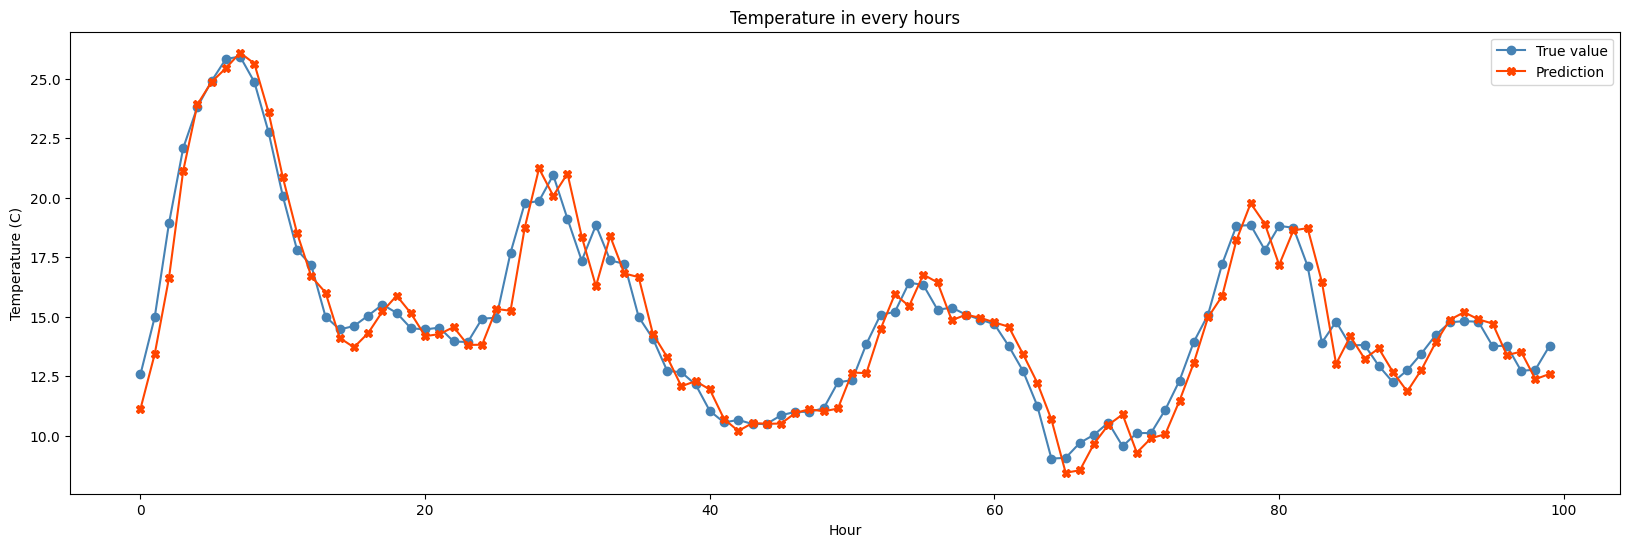

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)